In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from matplotlib.gridspec import GridSpec

In [2]:
# Read in data and assign X and y
data = pd.read_csv('fe_train_data.csv', index_col=0)
y = data[['isGoal']]
X = data.drop(columns = 'isGoal')
X

,gameID,distanceFromNet,angleFromNet,emptyNet
67,2015020364,43.8292,27.1497,0
68,2015020364,13.4164,26.5651,0
69,2015020364,12.3693,-75.9638,0
70,2015020364,9.8995,45.0000,0
71,2015020364,42.2019,-13.7070,0
...,...,...,...,...
467091,2015020035,41.1461,-25.9423,0
467092,2015020035,56.0000,0.0000,0
467093,2015020035,40.7185,24.6769,0
467094,2015020035,18.0278,56.3099,0


In [3]:
def Log_reg(X, y, feature_list):
    '''
    Arguments:
    X = pd.dataframe X
    y = target labels
    feature_list = list of features
    '''
    #print(X[feature_list])
    X_train,X_val,y_train,y_val = train_test_split(X[feature_list], y, test_size=0.2, random_state=42)

    # Logistic regression model fitting
    clf = LogisticRegression()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    
    #X_test_pred_proba = clf.predict_proba(X_test)
    pred_probs = clf.predict_proba(X_val)
    
    return X_val, y_val, y_pred, accuracy,  pred_probs

In [4]:
def plot_roc_all_feat(X, y):

    fig = plt.figure(figsize=(12,10))
    
    feature_list = (['distanceFromNet'], ['angleFromNet'], ['distanceFromNet', 'angleFromNet']  )
    feature_color_list = ['red', 'blue', 'green']
    plot_label_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']
    
    for i, feature in enumerate(feature_list):
        X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature)           
        print(f'Accuracy score is {accuracy}')
            
        plot_color = feature_color_list[i]
        plot_label = plot_label_list[i]
            
        probs_isgoal = pred_probs[:,1]
        fpr, tpr, _ = roc_curve(y_val,probs_isgoal)
        roc_auc = auc(fpr,tpr)
            
        plt.plot(fpr, tpr, color = plot_color, label = f'{plot_label} '+'AUC = %0.2f' % roc_auc, lw=2) 
        
    #Random Baseline
    baseline_is_goal = np.random.uniform(0,1,probs_isgoal.shape[0])
    plot_color = 'Magenta'
    plot_label = 'Random Baseline'
    fpr, tpr, _ = roc_curve(y_val,baseline_is_goal)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, color = plot_color, label = f'{plot_label} '+'AUC = %0.2f' % roc_auc, lw=2)
            
    
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    
    plt.title('ROC Curves', fontsize=20)
    plt.legend(loc=2,prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)    
    plt.grid(True)
    plt.show()

Accuracy score is 0.9041387332782319
Accuracy score is 0.9041387332782319
Accuracy score is 0.9041387332782319


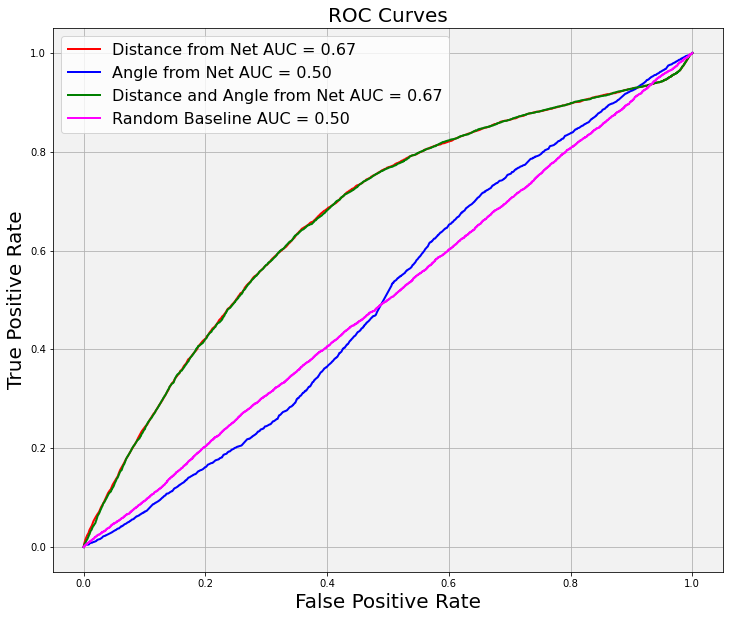

In [5]:
plot_roc_all_feat(X,y)

In [6]:
def calc_percentile(pred_probs, y_val):
    
    #Create a df for shot probabilities
    df_probs = pd.DataFrame(pred_probs)
    df_probs = df_probs.rename(columns={0: "Not_Goal_prob", 1: "Goal_prob"})
    
    # Combining 'Goal Probability' and 'Is Goal' into one df. 
    df_probs = pd.concat([df_probs["Goal_prob"].reset_index(drop=True), y_val["isGoal"].reset_index(drop=True)],axis=1)
    
    # Computing and adding Percentile Column
    percentile_values=df_probs['Goal_prob'].rank(pct=True)
    df_probs['Percentile'] = percentile_values*100
    df_percentile = df_probs.copy()
    
    return df_percentile

In [7]:
def goal_rate(df_percentile):
   
    rate_list = []
    
    # Find total number of goals
    total_goals = df_percentile['isGoal'].value_counts()[1]
   
    
    bin_width = 5

    i = 0
    i_list = []
    
    
    while i< (100-bin_width+1):  # 95 is the lower bound of last bin
        i_list.append(i)

        # i-th bin size
        bin_lower_bound = i
        bin_upper_bound = i + bin_width

        # finding rows have percentiles fall in this range
        bin_rows = df_percentile[(df_percentile['Percentile']>=bin_lower_bound) & (df_percentile['Percentile']<bin_upper_bound)]
        
        # Calculating the goal rate from total number of goals and shots in each bin_rows
        goals = bin_rows['isGoal'].value_counts()[1]      
        shots = len(bin_rows) #total shots in bin_rows
        rate = (goals/shots)*100 # goal rate in pecerntage

        rate_list.append(rate)

        i+=bin_width
    
    # Creating a new dataframe Combining goal rate list and percentile list 
    goal_rate_df = pd.DataFrame(list(zip(rate_list, i_list)),columns=['Rate', 'Percentile'])
    
    return goal_rate_df

In [8]:
def plot_goal_rate_all_feat(X, y):

    fig = plt.figure(figsize=(12,10))
    
    feature_list = (['distanceFromNet'], ['angleFromNet'], ['distanceFromNet', 'angleFromNet']  )
    feature_color_list = ['red', 'blue', 'green']
    plot_label_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']
    
    #if model_name == 'LR':
    for i, feature in enumerate(feature_list):
            
        X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature)   
        print(f'Accuracy score is {accuracy}')
            
        plot_color = feature_color_list[i]
        plot_label = plot_label_list[i]
            
        df_percentile =  calc_percentile(pred_probs, y_val)
        goal_rate_df = goal_rate(df_percentile)
        goal_rate_x = goal_rate_df['Percentile']
        goal_rate_y = goal_rate_df['Rate']
        plt.plot(goal_rate_x,goal_rate_y, color = plot_color, label = f'{plot_label}' )
                 
        
    #Random Baseline
    probs_isgoal = pred_probs[:,1]
    baseline_is_goal = np.random.uniform(0,1,probs_isgoal.shape[0])
    no_baseline_goal = np.array([(1-i) for i in baseline_is_goal])
    random_probs = np.column_stack((baseline_is_goal, no_baseline_goal))
    df_percentile =  calc_percentile(random_probs, y_val)
    goal_rate_df = goal_rate(df_percentile)
    goal_rate_x = goal_rate_df['Percentile']
    goal_rate_y = goal_rate_df['Rate']
        
    plot_color = 'Magenta'
    plot_label = 'Random Baseline'
    plt.plot(goal_rate_x,goal_rate_y, color = plot_color, label = f'{plot_label}' )

        
            
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    
    ax.set_ylim([0,100])
    ax.set_xlim([0,100])
    ax.invert_xaxis()
    major_ticks = np.arange(0, 110, 10)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    
    plt.grid(True)
    plt.title('Goal Rate', fontsize=20)
    plt.xlabel('Shot probability model percentile', fontsize=16)
    plt.ylabel('Goals / (Shots+Goals)%', fontsize=16)
    plt.show()
            

Accuracy score is 0.9041387332782319
Accuracy score is 0.9041387332782319
Accuracy score is 0.9041387332782319


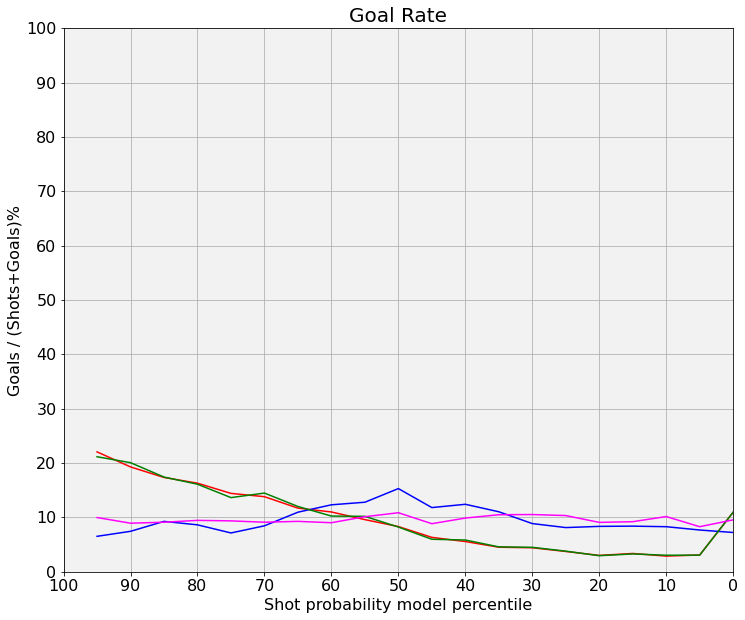

In [9]:
plot_goal_rate_all_feat(X,y)

In [10]:
def plot_cumulative_rate_all_feat(X, y):

    fig = plt.figure(figsize=(12,10))
    
    feature_list = (['distanceFromNet'], ['angleFromNet'], ['distanceFromNet', 'angleFromNet']  )
    feature_color_list = ['red', 'blue', 'green']
    plot_label_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']
    
    #if model_name == 'LR':
    for i, feature in enumerate(feature_list):
            
        X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature)   
        print(f'Accuracy score is {accuracy}')
            
        plot_color = feature_color_list[i]
        plot_label = plot_label_list[i]
            
        df_percentile =  calc_percentile(pred_probs, y_val)
        df_precentile_only_goal = df_percentile[df_percentile['isGoal'] == 1]
        ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile, 
                              color=plot_color)

                 
        
    #Random Baseline
    probs_isgoal = pred_probs[:,1]
    baseline_is_goal = np.random.uniform(0,1,probs_isgoal.shape[0])
    no_baseline_goal = np.array([(1-i) for i in baseline_is_goal])
    random_probs = np.column_stack((baseline_is_goal, no_baseline_goal))
    df_percentile =  calc_percentile(random_probs, y_val)
    df_precentile_only_goal = df_percentile[df_percentile['isGoal'] == 1]
        
    plot_color = 'Magenta'
    plot_label = 'Random Baseline'
    ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile, 
                              color=plot_color)
 
            
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    xvals = ax.get_xticks()
    ax.set_xticklabels(100 - xvals.astype(np.int32), fontsize=16)
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=16)
    ax.set_xlabel('Shot probability model percentile', fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_title(f"Cumulative % of Goals", fontsize=20)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    plot_label_list.append('Random Baseline')
    plt.legend(labels=plot_label_list, fontsize=16)
    plt.show()

Accuracy score is 0.9041387332782319
Accuracy score is 0.9041387332782319
Accuracy score is 0.9041387332782319


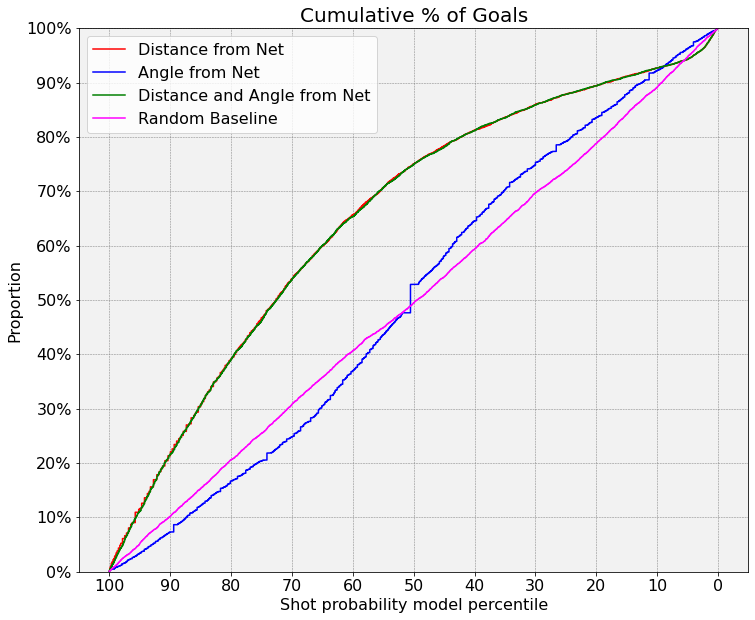

In [11]:
plot_cumulative_rate_all_feat(X, y)

In [12]:
def plot_calibration_all_feat(X, y):

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    
    feature_list = [['distanceFromNet'], ['angleFromNet'], ['distanceFromNet', 'angleFromNet']  ]
    feature_color_list = ['red', 'blue', 'green']
    plot_label_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']
    
    feature_list.append('RandonBaseline')
    
    #if model_name == 'LR':
    for i, feature in enumerate(feature_list):
            
        if feature != 'RandonBaseline':
            
            X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature)   
            print(f'Accuracy score is {accuracy}')
                
            y_val_is_goal = y_val['isGoal']
            pred_probs_is_goal = pred_probs[:,1] 
            
            plot_color = feature_color_list[i]
            plot_label = plot_label_list[i]
            
        else:
            random_goal_prob = np.random.uniform(0, 1, len(y_val))
            random_goal_prob_label = np.zeros( (len(random_goal_prob),1) )
            random_goal_prob_label[:,][np.where(random_goal_prob>0.5)]=1
                
            y_val_is_goal = random_goal_prob_label.copy()
            pred_probs_is_goal = random_goal_prob.copy()
            print(np.unique(y_val_is_goal, return_counts=True))
            plot_color = 'magenta'
            plot_label = 'Random Baseline'
           
        ax_display = CalibrationDisplay.from_predictions(y_val_is_goal,pred_probs_is_goal, n_bins=50, 
                                                             ax=ax_calibration_curve, color=plot_color, label=plot_label)
   
    
    ax_calibration_curve.grid()
    plt.title("Calibration plots", fontsize=20)
    plt.legend(loc=2,prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.ylabel('Fraction of positives', fontsize=20)
    plt.xlabel('Mean predicted probability', fontsize=20)
    plt.show()

Accuracy score is 0.9041387332782319
Accuracy score is 0.9041387332782319
Accuracy score is 0.9041387332782319
(array([0., 1.]), array([32590, 32744], dtype=int64))


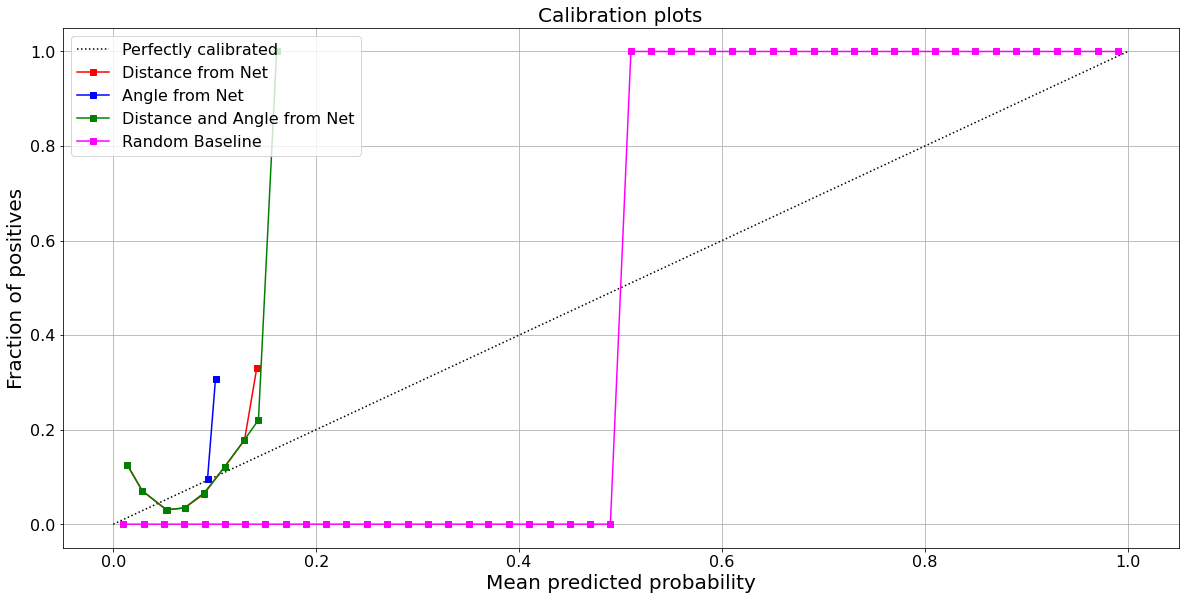

In [13]:
plot_calibration_all_feat(X, y)